# PyTorch Quick Intro
From https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision

In [23]:
x = torch.empty(5, 3)
print(x)
print(torch.sum(x).double())
print(torch.sum(x).long())

tensor([[9.3674e-39, 1.0745e-38, 1.0653e-38],
        [9.5510e-39, 1.0561e-38, 1.0194e-38],
        [1.1112e-38, 1.0561e-38, 9.9184e-39],
        [1.0653e-38, 4.1327e-39, 1.0194e-38],
        [1.0469e-38, 8.9082e-39, 1.5134e-43]])
tensor(1.3702e-37, dtype=torch.float64)
tensor(0)


In [24]:
x.size()

torch.Size([5, 3])

In [25]:
x.shape

torch.Size([5, 3])

In [26]:
x = x.view(3, 1, 5)

In [27]:
x[0,0,0].item()

9.36736213926e-39

In [28]:
x = x.numpy()

In [29]:
x = torch.from_numpy(x)

### Basic neural nets

In [96]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(in_features=16 * 6 * 6, out_features=120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Netv2(
  (conv1): ConvBlock(
    (conv): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_projection): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv2): ConvBlock(
    (conv): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_projection): Conv2d(6, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [97]:
params = list(net.parameters()) #learnable parameters
print(len(params))
print(params[0].size())  # conv1's .weight

18
torch.Size([6, 1, 3, 3])


In [99]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

torch.Size([1, 16, 8, 8])
tensor([[-0.3577,  0.1028, -0.0283, -0.3649, -0.4090,  0.0551,  0.0464, -0.2375,
          0.5805, -0.0632]], grad_fn=<AddmmBackward>)
torch.Size([1, 16, 8, 8])
tensor(1.0828, grad_fn=<MseLossBackward>)


In [105]:
iterations = 10

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
for i in range(iterations):
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()    # Does the update
    print("MSE for iter 1: {:.7f}".format(loss.item()))

torch.Size([1, 16, 8, 8])
MSE for iter 1: 0.0000000
torch.Size([1, 16, 8, 8])
MSE for iter 1: 0.0000000
torch.Size([1, 16, 8, 8])
MSE for iter 1: 0.0000000
torch.Size([1, 16, 8, 8])
MSE for iter 1: 0.0000000
torch.Size([1, 16, 8, 8])
MSE for iter 1: 0.0000000
torch.Size([1, 16, 8, 8])
MSE for iter 1: 0.0000000
torch.Size([1, 16, 8, 8])
MSE for iter 1: 0.0000000
torch.Size([1, 16, 8, 8])
MSE for iter 1: 0.0000000
torch.Size([1, 16, 8, 8])
MSE for iter 1: 0.0000000
torch.Size([1, 16, 8, 8])
MSE for iter 1: 0.0000000


### CIFAR-10 Classification with PyTorch

##### Image Classifier

In [110]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


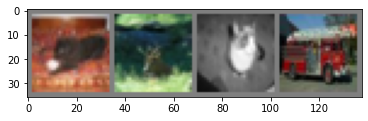

  dog  deer   cat truck


In [111]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

##### Define custom layers

In [109]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, use_residual=True, pool_size=(2,2)):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels, 
                              kernel_size=kernel_size,
                              padding=1)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.pool_size = pool_size
        
        if use_residual:
            self.linear_projection = nn.Conv2d(in_channels=in_channels, 
                                               out_channels=out_channels, 
                                               kernel_size=(1,1),
                                               padding=0)
        
    def forward(self, inputs):
        
        residual = self.linear_projection(inputs)
        
        x = self.conv(inputs)
        x = F.relu(x)
        x = self.batchnorm(x)
        x += residual
        x = F.max_pool2d(x, kernel_size=self.pool_size)
        
        return x

In [115]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Netv2(nn.Module):
    def __init__(self):
        super(Netv2, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = ConvBlock(in_channels=3, out_channels=6, kernel_size=(3,3))
        self.conv2 = ConvBlock(in_channels=6, out_channels=16, kernel_size=(3,3))
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(in_features=16 * 8 * 8, out_features=120) 
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Netv2()

In [116]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [117]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.768
[1,  4000] loss: 1.499
[1,  6000] loss: 1.409
[1,  8000] loss: 1.330
[1, 10000] loss: 1.268
[1, 12000] loss: 1.235
[2,  2000] loss: 1.107
[2,  4000] loss: 1.092
[2,  6000] loss: 1.083
[2,  8000] loss: 1.091
[2, 10000] loss: 1.063
[2, 12000] loss: 1.055
Finished Training


In [123]:
# Save
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Load
net = Netv2()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

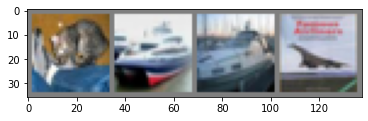

GroundTruth:    cat  ship  ship plane


In [118]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [119]:
outputs = net(images)

In [120]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  ship plane  ship


In [121]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


In [122]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 72 %
Accuracy of  bird : 55 %
Accuracy of   cat : 37 %
Accuracy of  deer : 54 %
Accuracy of   dog : 38 %
Accuracy of  frog : 82 %
Accuracy of horse : 68 %
Accuracy of  ship : 77 %
Accuracy of truck : 71 %


In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [64]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [65]:
inputs, labels = data[0].to(device), data[1].to(device)